In [15]:
import warnings
warnings.filterwarnings('ignore')

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
%matplotlib inline


In [16]:
import os

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [17]:
np.random.seed(42)

In [19]:
train = pd.read_csv('/kaggle/input/mnist-digit/train.csv', dtype=np.float32)
test = pd.read_csv('/kaggle/input/mnist-digit/test.csv', dtype=np.float32)

In [20]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def plot_distribution_classes(x_values, y_values):

    fig = go.Figure(data=[go.Bar(
                x=x_values, 
                y=y_values,
                text=y_values
    )])

    fig.update_layout(height=600, width=1200, title_text="Distribution of classes")
    fig.update_xaxes(type="category")

    fig.show()

In [22]:
x = np.sort(train.label.unique())
y = train.label.value_counts().sort_index()

plot_distribution_classes(x, y)

In [23]:
def preprocessing(train, test, split_train_size = 0.2):
    
    targets = train.label.values
    features = train.drop(["label"], axis = 1).values
    
    features = features/255.
    X_test = test.values/255.
     
    X_train, X_val, y_train, y_val = train_test_split(features,
                                                      targets,
                                                      test_size = split_train_size,
                                                      random_state = 42) 
    
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor) 
    
    X_test = torch.from_numpy(X_test)
    
    return X_train, y_train, X_val, y_val, X_test

In [24]:
X_train, y_train, X_val, y_val, X_test = preprocessing(train, test)

print(f'Shape of training data: {X_train.shape}')
print(f'Shape training labels: {y_train.shape}')
print(f'Shape of validation data: {X_val.shape}')
print(f'Shape of valiation labels: {y_val.shape}')
print(f'Shape of testing data: {X_test.shape}')

Shape of training data: torch.Size([33600, 784])
Shape training labels: torch.Size([33600])
Shape of validation data: torch.Size([8400, 784])
Shape of valiation labels: torch.Size([8400])
Shape of testing data: torch.Size([28000, 784])


In [25]:
BATCH_SIZE = 100
N_ITER = 2500
EPOCHS = 9

train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor = torch.utils.data.TensorDataset(X_test)

train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
val_loader = torch.utils.data.DataLoader(val_tensor, 
                                         batch_size = BATCH_SIZE, 
                                         shuffle = False)
test_loader = torch.utils.data.DataLoader(test_tensor, 
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [26]:
def display_images(graph_indexes = np.arange(9)):
    
    plt.figure(figsize=(12,12))
    for graph_index in graph_indexes:
        
        index = random.randint(1, X_train.shape[0])
        
        label = y_train[index].numpy()
        
        plt.subplot(330 + 1 + graph_index)
        plt.title('Label: %s \n'%label,
                 fontsize=18)
        
        plt.imshow(X_train[index].resize(28,28), cmap=plt.get_cmap('gray'))
        
    plt.subplots_adjust(bottom = 0.001)
    plt.subplots_adjust(top = 0.99)
    
    plt.show()

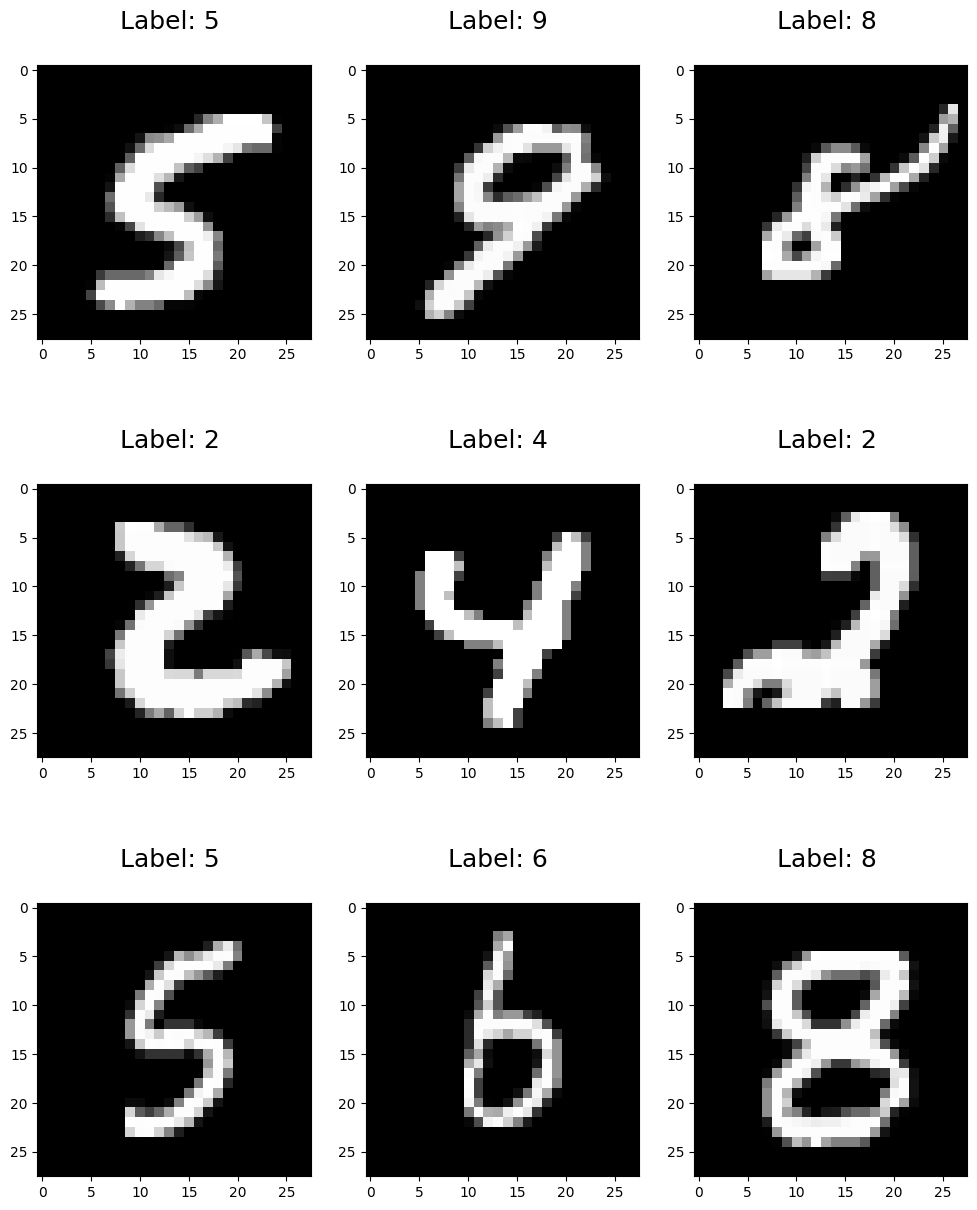

In [27]:
display_images()

In [28]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=0)
        self.relu1 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.dropout1 = nn.Dropout(0.25)

        self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(32*5*5, 256)
        
        self.dropout3 = nn.Dropout(0.25)
     
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        
        out = self.c1(x) 
        out = self.relu1(out) 
        out = self.maxpool1(out) 
        out = self.dropout1(out) 
        
        out = self.c2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = self.dropout2(out) 
        
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.dropout3(out)
        out = self.fc2(out) 
        
        return out

model = CNNModel()

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [29]:
def fit(epoch):
    
    print("Training...")
    model.train()
    
    exp_lr_scheduler.step()
    
    train_running_loss = 0.0
    train_running_correct = 0
    train_running_lr = optimizer.param_groups[0]['lr']
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28)), Variable(target)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch + 1, 
                 (batch_idx + 1) * len(data), 
                 len(train_loader.dataset),
                 BATCH_SIZE * (batch_idx + 1) / len(train_loader), 
                 loss.cpu().detach().numpy())
                 )
            
    train_loss = train_running_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_loader.dataset)    
    
    return train_loss, train_accuracy, train_running_lr

In [30]:
def validate(data_loader):
    
    print("Validating...")

    model.eval()
    val_preds = torch.LongTensor()
    val_proba = torch.LongTensor()

    val_running_loss = 0.0
    val_running_correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data.view(BATCH_SIZE, 1, 28, 28), volatile=False), Variable(target)
        
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        proba = torch.nn.functional.softmax(output.data)

        val_running_correct += pred.eq(target.data.view_as(pred)).cpu().sum() 
        
        val_preds = torch.cat((val_preds, pred), dim=0)
        val_proba = torch.cat((val_proba, proba))

    val_loss = val_running_loss / len(data_loader.dataset)
    val_accuracy = 100. * val_running_correct / len(data_loader.dataset) 
    
    return val_loss, val_accuracy, val_preds, val_proba

In [31]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
val_preds, val_proba = [], []
train_lr = []

for epoch in range(EPOCHS):
    
    print(f"Epoch {epoch+1} of {EPOCHS}\n")
    
    train_epoch_loss, train_epoch_accuracy, train_epoch_lr = fit(epoch)
    val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_proba = validate(val_loader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_lr.append(train_epoch_lr)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_preds.append(val_epoch_preds)
    val_proba.append(val_epoch_proba)
    
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}\n')


Epoch 1 of 9

Training...
Train Epoch: 1 [5000/33600 (15%)]	Loss: 0.418945
Train Epoch: 1 [10000/33600 (30%)]	Loss: 0.136181
Train Epoch: 1 [15000/33600 (45%)]	Loss: 0.196824
Train Epoch: 1 [20000/33600 (60%)]	Loss: 0.219676
Train Epoch: 1 [25000/33600 (74%)]	Loss: 0.036393
Train Epoch: 1 [30000/33600 (89%)]	Loss: 0.083686
Validating...
Train Loss: 0.0025, Train Acc: 91.82
Val Loss: 0.0008, Val Acc: 97.50

Epoch 2 of 9

Training...
Train Epoch: 2 [5000/33600 (15%)]	Loss: 0.066425
Train Epoch: 2 [10000/33600 (30%)]	Loss: 0.232275
Train Epoch: 2 [15000/33600 (45%)]	Loss: 0.066410
Train Epoch: 2 [20000/33600 (60%)]	Loss: 0.065938
Train Epoch: 2 [25000/33600 (74%)]	Loss: 0.115368
Train Epoch: 2 [30000/33600 (89%)]	Loss: 0.064571
Validating...
Train Loss: 0.0010, Train Acc: 96.94
Val Loss: 0.0007, Val Acc: 97.86

Epoch 3 of 9

Training...
Train Epoch: 3 [5000/33600 (15%)]	Loss: 0.029723
Train Epoch: 3 [10000/33600 (30%)]	Loss: 0.111527
Train Epoch: 3 [15000/33600 (45%)]	Loss: 0.071651
Train

In [32]:
def plot_history():

    plt.figure(figsize = (20,15))
    
    plt.subplot(221)
    
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    
    plt.subplot(222)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    plt.subplot(223)
    plt.plot(train_lr)
    plt.title('learning rate')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.grid()
    
    plt.show()

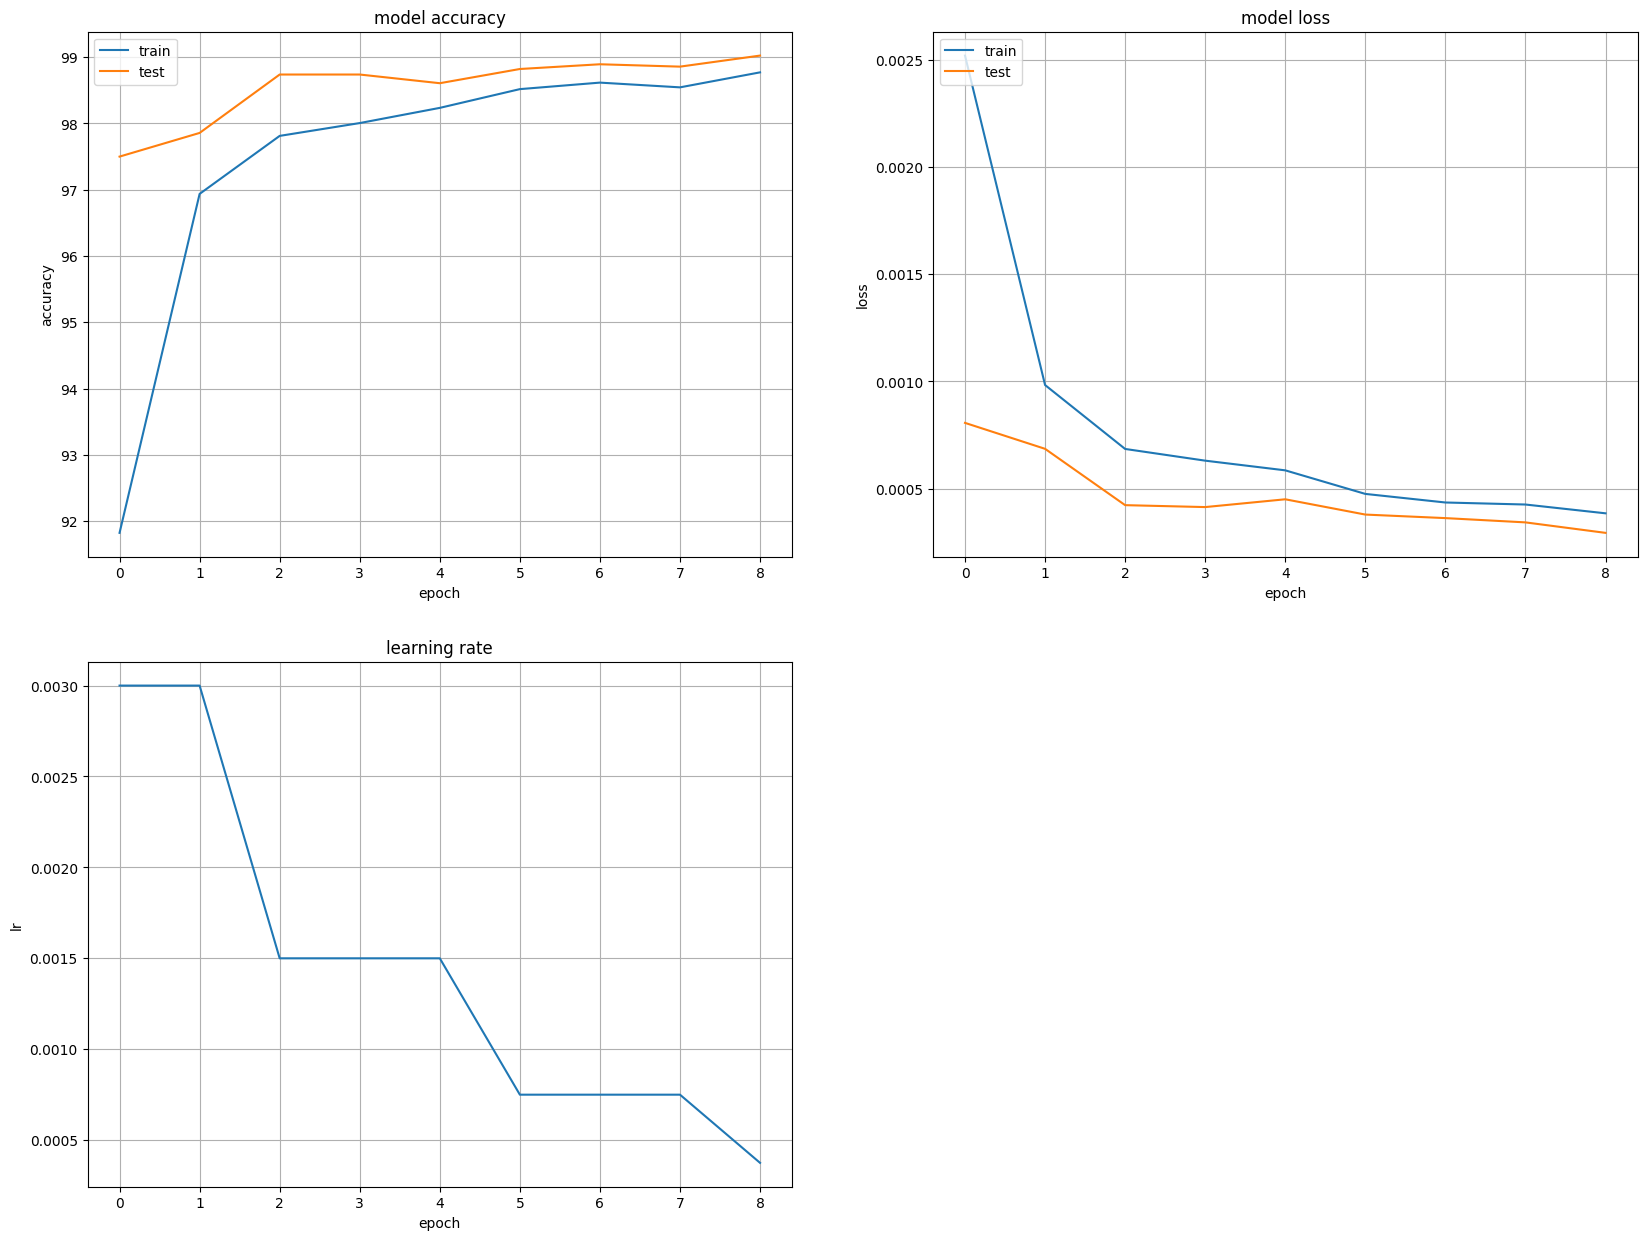

In [33]:
plot_history()

In [34]:
def plot_confusion_matrix(confusion_matrix, 
                          cmap=plt.cm.Reds):
    
    classes = range(10)
    
    plt.figure(figsize=(8,8))
    plt.imshow(confusion_matrix, 
               interpolation='nearest', 
               cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

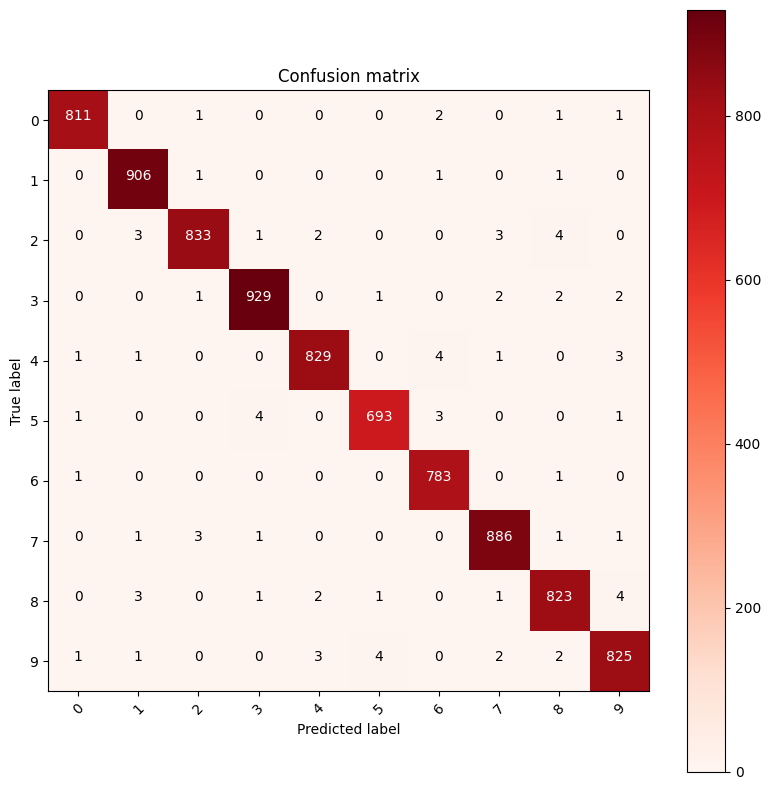

In [35]:
y_pred_classes = val_preds[EPOCHS - 1].cpu().numpy().ravel()

cm = confusion_matrix(y_val, y_pred_classes) 

plot_confusion_matrix(cm)

In [36]:
def display_predicted_images(graph_indexes = np.arange(9)):

    plt.figure(figsize=(12,12))
    
    for graph_index in graph_indexes:
        
        index = random.randint(1, X_val.shape[0])
        
        predicted_label = y_pred_classes[index]
        true_label = y_val[index]
        
        plt.subplot(330 + 1 + graph_index)
        plt.title('Predicted label: %s \n'%predicted_label+\
                  'True label %s \n'%true_label.item(),
                 fontsize=18)
        plt.imshow(X_val[index].view(28,28), cmap=plt.get_cmap('gray'))
        
    plt.subplots_adjust(bottom = 0.001) 
    plt.subplots_adjust(top = 0.99)
    plt.show()

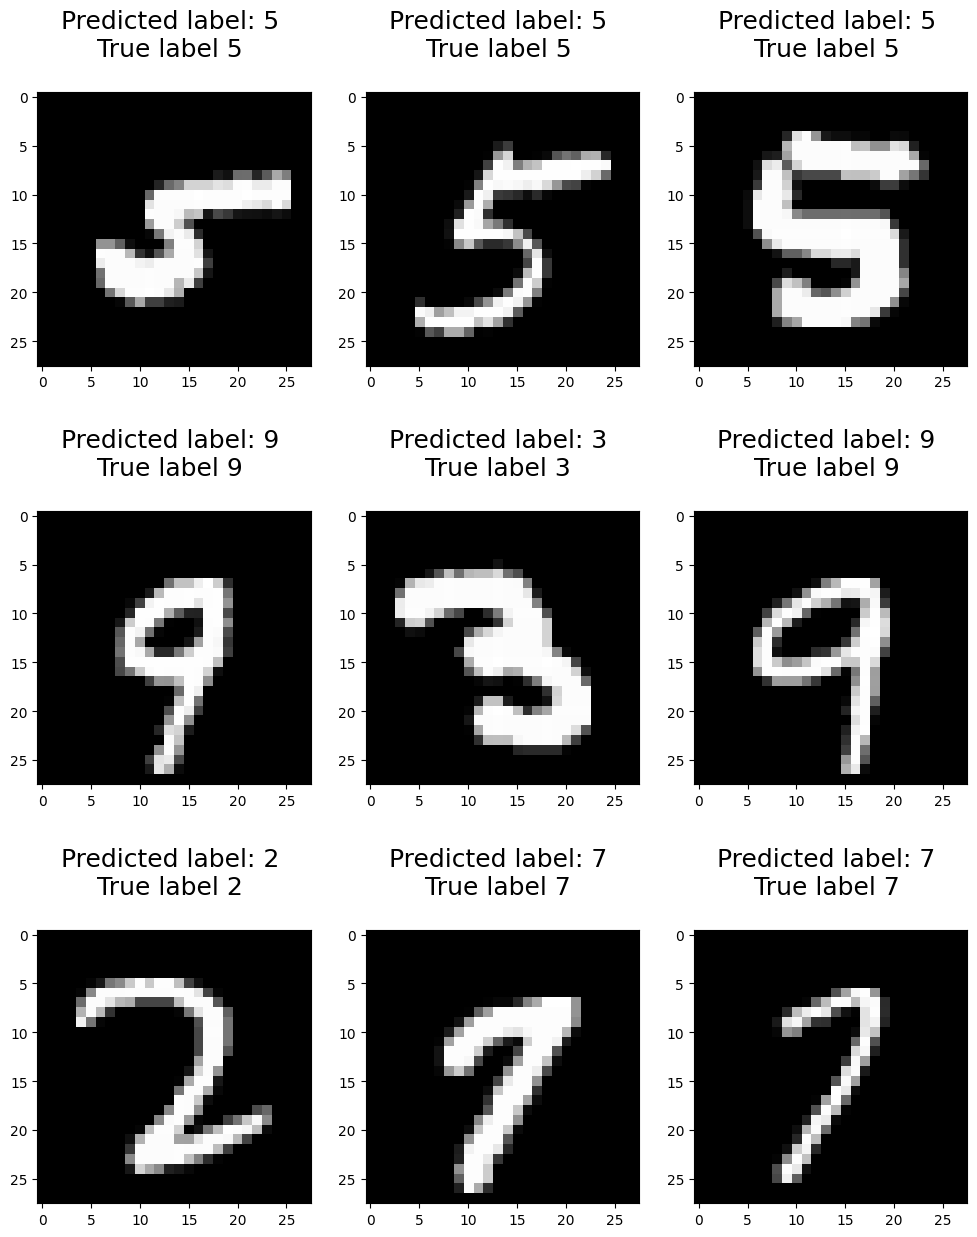

In [37]:
display_predicted_images()